In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import os
if os.getcwd().split('/')[-1] != "vegetation_health":
    os.chdir('..')
    
assert os.getcwd().split('/')[-1] == "vegetation_health", f"Working directory should be the root (), currently: {os.getcwd()}"

In [4]:
from predictor.analysis.plot_results import create_dataset_from_vars, plot_results
from predictor.analysis.utils import load_model_data

In [5]:
def drop_nans_and_flatten(dataArray):
    """flatten the array and drop nans from that array. Useful for plotting histograms.

    Arguments:
    ---------
    : dataArray (xr.DataArray)
        the DataArray of your value you want to flatten
    """
    # drop NaNs and flatten
    return dataArray.values[~np.isnan(dataArray.values)]


# Initialise the Paths and read in the data

In [6]:
data_dir = Path('./data')
processed_data=Path('data/processed')

normalising_dict_path = data_dir / "processed" / "normalizing_dict.json"
test_dir = processed_data / "ndvi"/"arrays"/"test"
train_dir = processed_data / "ndvi"/"arrays"/"train"
predictions_path = processed_data/"ndvi"/"arrays"/"preds.npy"

In [7]:
# read the predictions
preds = np.load(predictions_path)
true = np.load(processed_data / "ndvi" / 'arrays/test/y.npy')


In [8]:
# read in data that is fed through the models (train/test)
train_data = load_model_data("train")
test_data = load_model_data("test")

In [9]:
# create a xr.Dataset object
preds_xr = create_dataset_from_vars(preds, test_data.latlon, "preds", to_xarray=True)
true_xr = create_dataset_from_vars(true, test_data.latlon, "true", to_xarray=True)
ds = preds_xr.merge(true_xr)


In [10]:
difference = ds.true - ds.preds
da = xr.DataArray(difference, coords=[ds.lat, ds.lon], dims=['lat','lon'])
diff = da.to_dataset('difference')
ds = ds.merge(diff)

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
ds

<xarray.Dataset>
Dimensions:     (lat: 404, lon: 368)
Coordinates:
  * lat         (lat) float64 -4.975 -4.925 -4.875 -4.825 ... 15.07 15.12 15.17
  * lon         (lon) float64 32.62 32.68 32.72 32.77 ... 50.88 50.93 50.97
Data variables:
    preds       (lat, lon) float32 0.53142864 0.51000357 0.50388175 ... nan nan
    true        (lat, lon) float64 0.5559 0.5136 0.4928 0.4576 ... nan nan nan
    difference  (lat, lon) float64 0.02447 0.003596 -0.01108 ... nan nan nan

# Explore the output of the models

In [12]:
colors = sns.color_palette()

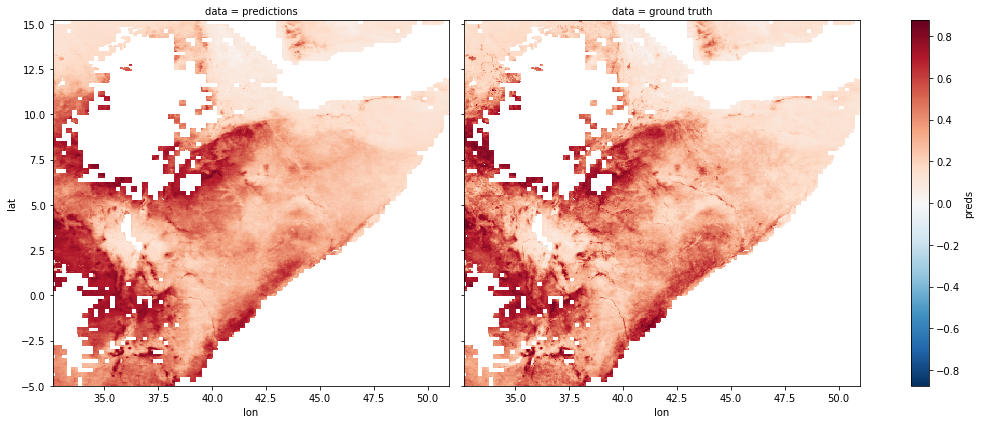

In [13]:
plot_results()

Text(0.5, 1.0, 'Distribution of Actual NDVI')

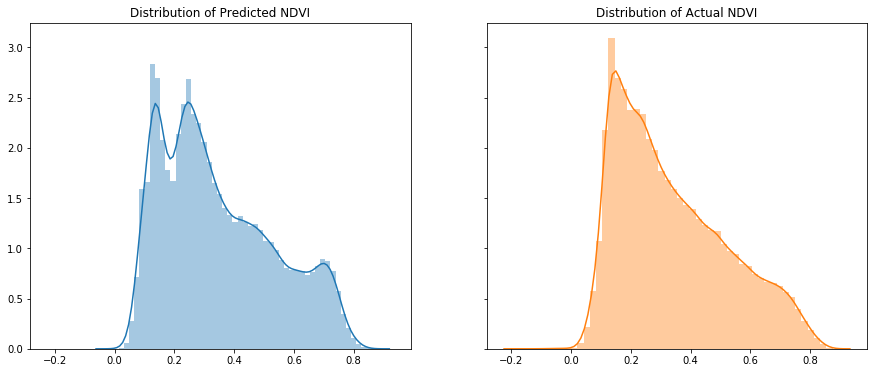

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True,figsize=(15,6))
sns.distplot(preds, ax=ax1)
ax1.set_title('Distribution of Predicted NDVI')
sns.distplot(test_data.y, ax=ax2,color=colors[1])
ax2.set_title('Distribution of Actual NDVI')

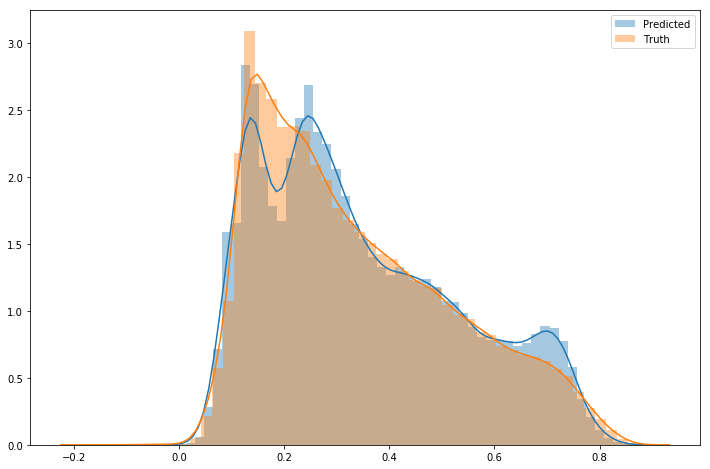

In [94]:
fig,ax=plt.subplots(figsize=(12,8))
sns.distplot(preds,ax=ax, label="Predicted")
sns.distplot(test_data.y,ax=ax, label="Truth")
plt.legend();
fig.savefig(Path("/Users/tommylees") / "Downloads" / "distns.png")

In [21]:
print(f"Minimums  True: {min(true)} Predicted: {min(preds)}")
print(f"Maximums  True: {max(true)} Predicted: {max(preds)}")

Minimums  True: -0.16679999232292175 Predicted: -0.0035918354988098145
Maximums  True: 0.8747999668121338 Predicted: 0.8604661822319031


## Analysis of Different NDVI Conditions (poor/good growing conditions)

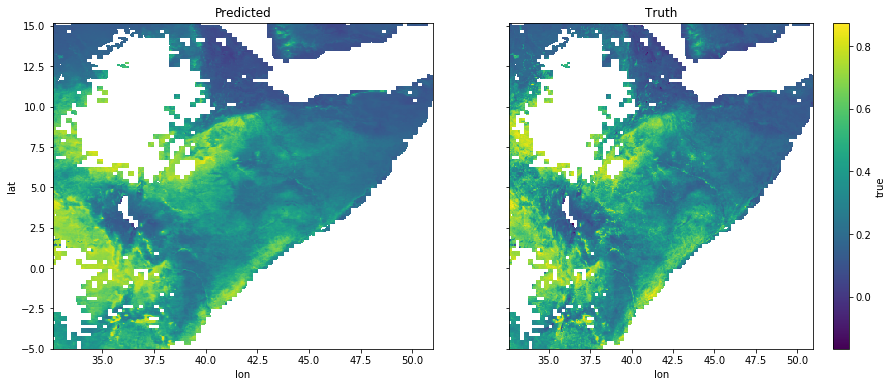

In [182]:
def plot_spatial_preds_vs_true(ds, cmap='viridis', unsaturate=False):
    """plot the spatial patterns of the predicted vs. true values
    
    TODO: Make them take up the same space (colorbar means that predicted is bigger)
    """
    fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True, figsize=(15,6))
    
    # get the colorbar min/max from the values in the `ds` object
    if unsaturate:
        max_ = np.quantile(drop_nans_and_flatten(ds.true),0.9) 
        min_ = np.quantile(drop_nans_and_flatten(ds.true),0.1) 
    else:
        max_ =  max(drop_nans_and_flatten(ds.true))
        min_ =  min(drop_nans_and_flatten(ds.true))
    
#     max(
#         max(drop_nans_and_flatten(ds.preds)),
#         max(drop_nans_and_flatten(ds.true))
#     )
#     min(
#         min(drop_nans_and_flatten(ds.preds)),
#         min(drop_nans_and_flatten(ds.true))
#     #    ds.preds.min().values,ds.true.min().values
#     )
    kwargs = {'vmin':min_,'vmax':max_,'cmap':cmap}
    
    ds.preds.plot(ax=ax1, add_colorbar=False,**kwargs)
    ax1.set_title('Predicted')
    ds.true.plot(ax=ax2, add_colorbar=True,**kwargs)
    ax2.set_title('Truth')
    ax2.set_ylabel('')
    
    return fig,(ax1,ax2)
    
plot_spatial_preds_vs_true(ds);

### LOW NDVI

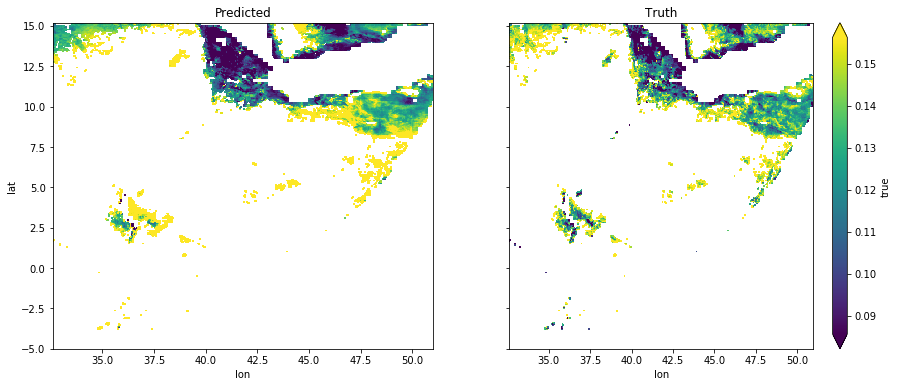

In [183]:
low_ndvi_thresh = np.quantile(true, 0.2)

low = ds.where(ds.true < low_ndvi_thresh)
plot_spatial_preds_vs_true(low,unsaturate=True);

# fig,ax=plt.subplots()
# low.difference.plot(ax=ax)

### HIGH NDVI

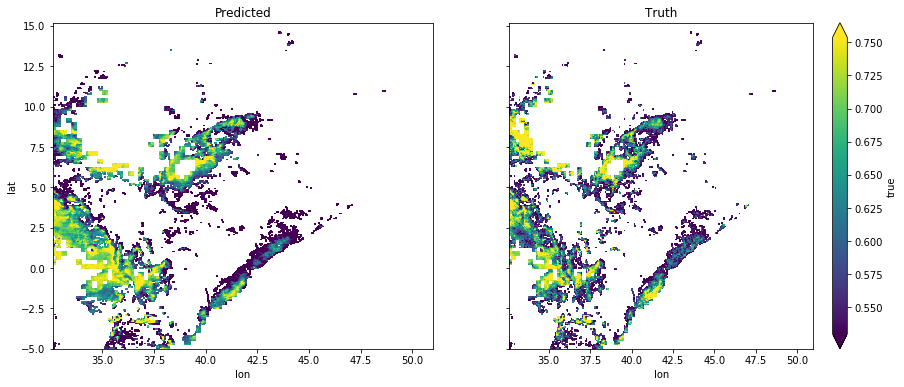

In [179]:
high_ndvi_thresh = np.quantile(true, 0.8)

high = ds.where(ds.true > high_ndvi_thresh)
plot_spatial_preds_vs_true(high,unsaturate=True);

### MID NDVI

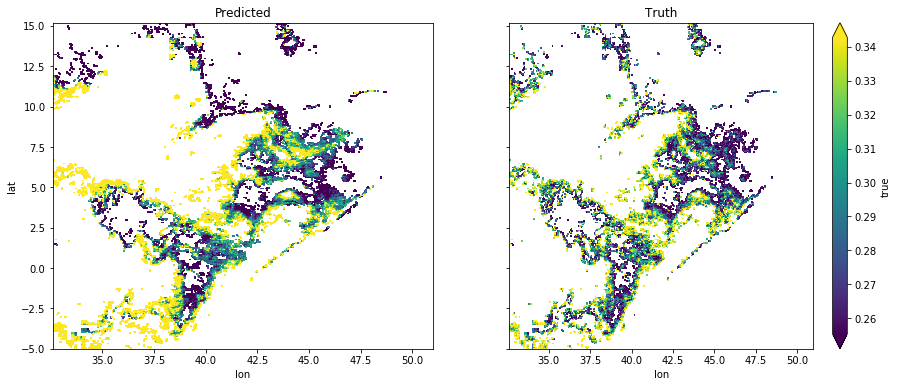

In [184]:
mid_upper_thresh = np.quantile(true, 0.6)
mid_lower_thresh = np.quantile(true, 0.4)

mid = ds.where((ds.true > mid_lower_thresh) & (ds.true < mid_upper_thresh))
plot_spatial_preds_vs_true(mid,unsaturate=True);

In [218]:
low_ndvi_thresh = np.quantile(true, 0.2)
high_ndvi_thresh = np.quantile(true, 0.2)
mid_upper_thresh = np.quantile(true, 0.6)
mid_lower_thresh = np.quantile(true, 0.4)

condition_mid = (true > mid_lower_thresh) & (true < mid_upper_thresh)
condition_low = true < low_ndvi_thresh
condition_high = true > high_ndvi_thresh

def subset_of_predns(preds, true, condition):
    """Select subset of arrays (predictions and true) based
    on a condition (boolean array)
    """
    assert (len(preds) == len(true))&(len(condition) == len(true)), f"The arrays must be the same length! Currently:\npreds: {len(preds)} true: {len(true)} condition: {len(condition)}"
    return preds[condition], true[condition]

pred_low,true_low = subset_of_predns(preds, true, condition_low)
pred_med,true_med = subset_of_predns(preds, true, condition_mid)
pred_high,true_high = subset_of_predns(preds, true, condition_high)

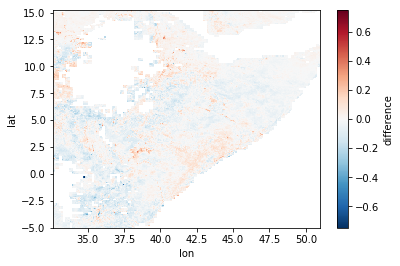

In [219]:
fig,ax=plt.subplots()
ds.difference.plot()

### Distributions of LOW MID HIGH

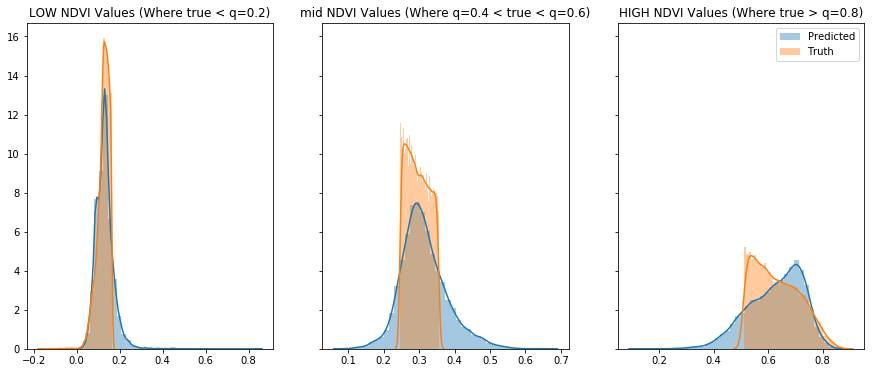

In [220]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,6), sharey=True)
sns.distplot(drop_nans_and_flatten(low.preds),ax=ax1,label='Predicted',bins=40,hist=True)
sns.distplot(drop_nans_and_flatten(low.true),ax=ax1,label='Truth',bins=40,hist=True)
ax1.set_title('LOW NDVI Values (Where true < q=0.2)')
sns.distplot(drop_nans_and_flatten(mid.preds),ax=ax2,label='Predicted',bins=40,hist=True)
sns.distplot(drop_nans_and_flatten(mid.true),ax=ax2,label='Truth',bins=40,hist=True)
ax2.set_title('mid NDVI Values (Where q=0.4 < true < q=0.6)')
sns.distplot(drop_nans_and_flatten(high.preds),ax=ax3,label='Predicted',bins=40,hist=True)
sns.distplot(drop_nans_and_flatten(high.true),ax=ax3,label='Truth',bins=40,hist=True)
ax3.set_title('HIGH NDVI Values (Where true > q=0.8)')
plt.legend()

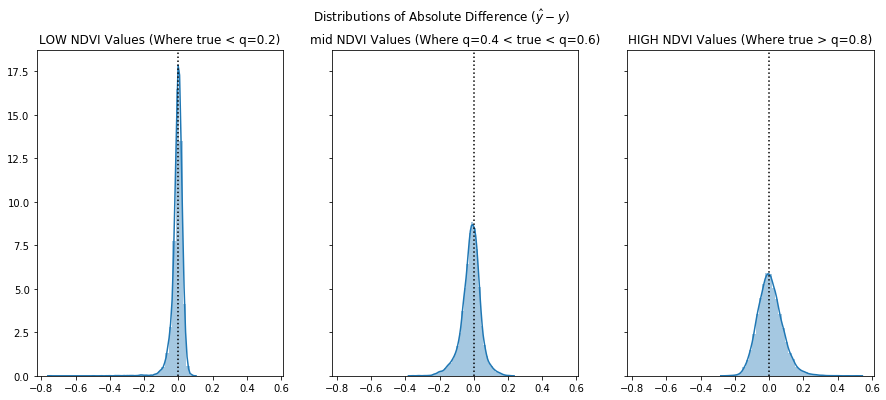

In [221]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,6), sharey=True, sharex=True)
sns.distplot(drop_nans_and_flatten(low.difference),ax=ax1,label='difference',bins=40,hist=True)
ax1.set_title('LOW NDVI Values (Where true < q=0.2)')
sns.distplot(drop_nans_and_flatten(mid.difference),ax=ax2,label='difference',bins=40,hist=True)
ax2.set_title('mid NDVI Values (Where q=0.4 < true < q=0.6)')
sns.distplot(drop_nans_and_flatten(high.difference),ax=ax3,label='difference',bins=40,hist=True)
ax3.set_title('HIGH NDVI Values (Where true > q=0.8)')
for ax in (ax1,ax2,ax3):
    ax.axvline(0, ls=':', color='k')
fig.suptitle('Distributions of Absolute Difference ($\hat{y} - y$)');
# plt.tight_layout()

# Forecast Verification

In [222]:
def calcuate_bias(preds, true):
    """The difference between the mean of the forecasts and the mean 
    of the observations. Could be expressed as a percentage of the 
    mean observation. Also known as overall bias, systematic bias, or
    unconditional bias. For categorical forecasts, bias (also known 
    as frequency bias) is equal to the total number of events forecast 
    divided by the total number of events observed. 

    $\frac{\hat{y} - y}{y} * 100$
    """
    bias = (preds.mean() - true.mean())
    pct_bias = bias / true.mean()*100
    
    return pct_bias

## Bias
with np.printoptions(precision=3, suppress=True):
    pct_bias = calcuate_bias(preds, true)
    print(f"Mean Bias = {pct_bias:.2f}%")
    
with np.printoptions(precision=3, suppress=True):
    low_bias = calcuate_bias(pred_low, true_low)
    med_bias = calcuate_bias(pred_med, true_med)
    high_bias = calcuate_bias(pred_high, true_high)
    
    print(f"Low NDVI Values Mean Bias = {low_bias:.2f}%")
    print(f"Med NDVI Values Mean Bias = {med_bias:.2f}%")
    print(f"High NDVI Values Mean Bias = {high_bias:.2f}%")

Mean Bias = 2.67%
Low NDVI Values Mean Bias = 4.21%
Med NDVI Values Mean Bias = 5.46%
High NDVI Values Mean Bias = 2.55%


In [223]:
# test_data.latlon

## Mean absolute Error
$$ \text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|.$$

In [226]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(true, preds)
print(f"Mean Absolute Error = {mae:.2f}")

low_mae = mean_absolute_error(pred_low, true_low)
med_mae = mean_absolute_error(pred_mid, true_mid)
high_mae = mean_absolute_error(pred_high, true_high)
print(f"LOW NDVI Mean Absolute Error = {low_mae:.2f}")
print(f"MED NDVI Mean Absolute Error = {med_mae:.2f}")
print(f"HIGH NDVI Mean Absolute Error = {high_mae:.2f}")

Mean Absolute Error = 0.04
LOW NDVI Mean Absolute Error = 0.02
MED NDVI Mean Absolute Error = 0.04
HIGH NDVI Mean Absolute Error = 0.05


### explained_variance_score
$$ explained\_{}variance(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}} $$

In [228]:
from sklearn.metrics import explained_variance_score

expl_var = explained_variance_score(true, preds)
print(f"Explained Variance = {expl_var:.2f}")

low_var = explained_variance_score(pred_low, true_low)
med_var = explained_variance_score(pred_med, true_med)
high_var = explained_variance_score(pred_high, true_high)
print(f"LOW NDVI Explained Variance = {low_var:.2f}")
print(f"MED NDVI Explained Variance = {med_var:.2f}")
print(f"HIGH NDVI Explained Variance = {high_var:.2f}")

Explained Variance = 0.90
LOW NDVI Explained Variance = 0.33
MED NDVI Explained Variance = 0.23
HIGH NDVI Explained Variance = 0.86


In [233]:
# explained\_{}variance(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}}

1 - (np.var(true_low - pred_low) / np.var(true_low))
# 1 - (np.var(true_high - pred_high) / np.var(true_high))
# 1 - (np.var(true_med - pred_med) / np.var(true_med))

-0.41586486340924367

### $R^2$ Score

In [239]:
from sklearn.metrics import r2_score

r2 = r2_score(true, preds)
print(f"R^2 Score = {r2:.2f}")

low_r2 = r2_score(pred_low, true_low)
med_r2 = r2_score(pred_med, true_med)
high_r2 = r2_score(pred_high, true_high)
print(f"LOW NDVI Explained Variance = {low_r2:.2f}")
print(f"MED NDVI Explained Variance = {med_r2:.2f}")
print(f"HIGH NDVI Explained Variance = {high_r2:.2f}")

R^2 Score = 0.90
LOW NDVI Explained Variance = 0.32
MED NDVI Explained Variance = 0.17
HIGH NDVI Explained Variance = 0.86


In [125]:
# https://stackoverflow.com/questions/40592630/get-coordinates-of-non-nan-values-of-xarray-dataset
# https://stackoverflow.com/a/40599583/9940782
da_stacked = low.stack(x=['lat','lon'])
da_stacked
# da_stacked[da_stacked.notnull()]
new_latlons = (da_stacked.x.where(da_stacked.preds.notnull()).values)

<xarray.DataArray (x: 148672)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=object)
Coordinates:
  * x        (x) MultiIndex
  - lat      (x) float64 -4.975 -4.975 -4.975 -4.975 ... -4.975 -4.975 -4.975
  - lon      (x) float64 32.62 32.68 32.72 32.77 ... 33.93 33.97 34.02 34.07

# Where is the model making the biggest mistakes?

In [308]:
def get_values_based_on_error_condition(ds, q, gt_lt="gt"):
    """"""
    coords=[coord for coord in ds.coords.keys()]
    vars_=[var for var in ds.variables.keys() if var not in coords]
    assert "difference" in vars_, f"Must have a difference variable in the ds object"
    
    if gt_lt == "gt":
        cond = abs(ds.difference) > abs(ds.difference).quantile(q=q) 
    else:
        cond = abs(ds.difference) < abs(ds.difference).quantile(q=q) 
        
    mask = ~((ds.where(cond)))[vars_[0]].isnull()
    mask = mask.drop('quantile')
    return mask

mask = get_values_based_on_error_condition(ds, q=0.95, gt_lt="gt")

<xarray.DataArray 'preds' (lat: 404, lon: 368)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float64 -4.975 -4.925 -4.875 -4.825 ... 15.07 15.12 15.17
  * lon      (lon) float64 32.62 32.68 32.72 32.77 ... 50.82 50.88 50.93 50.97

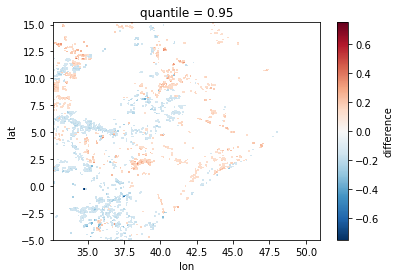

In [280]:
# where the abs difference is > 
q = 0.95
(ds
 .where(abs(ds.difference) > abs(ds.difference).quantile(q=q))
 .difference
 .plot()
)

In [281]:
mask = ~(ds.where(abs(ds.difference) > abs(ds.difference).quantile(q=q))).preds.isnull()
mask = mask.drop('quantile')
mask

<xarray.DataArray 'preds' (lat: 404, lon: 368)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 -4.975 -4.925 -4.875 -4.825 ... 15.07 15.12 15.17
  * lon      (lon) float64 32.62 32.68 32.72 32.77 ... 50.82 50.88 50.93 50.97

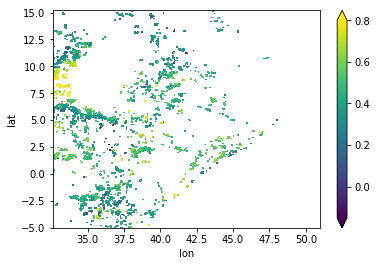

In [286]:
ds.true.where(mask).plot(cmap='viridis',vmin=-0.15,vmax=0.8)

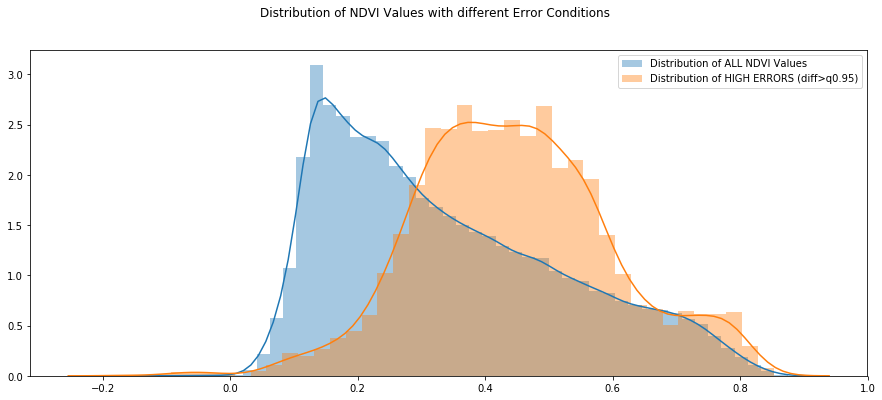

In [332]:
mask_q95=get_values_based_on_error_condition(ds, q=0.95, gt_lt="gt")
mask_q50_lower=get_values_based_on_error_condition(ds, q=0.5, gt_lt="lt")
mask_q50_upper=get_values_based_on_error_condition(ds, q=0.5, gt_lt="gt")

fig,ax=plt.subplots(figsize=(15,6))
sns.distplot(drop_nans_and_flatten(ds.true), label='Distribution of ALL NDVI Values', color=sns.color_palette()[0])
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q95)), label='Distribution of HIGH ERRORS (diff>q0.95)', color=sns.color_palette()[1])
# sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_lower)), label='Distribution of Low Errors (diff<q0.5)', color=sns.color_palette()[2])
# sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_upper)), label='Distribution of Higher Errors (diff>q0.5)', color=sns.color_palette()[3])
plt.legend();
fig.suptitle(f'Distribution of NDVI Values with different Error Conditions'); #\ne.g. (Abs Diff) is > q0.95');''

# sns.distplot()

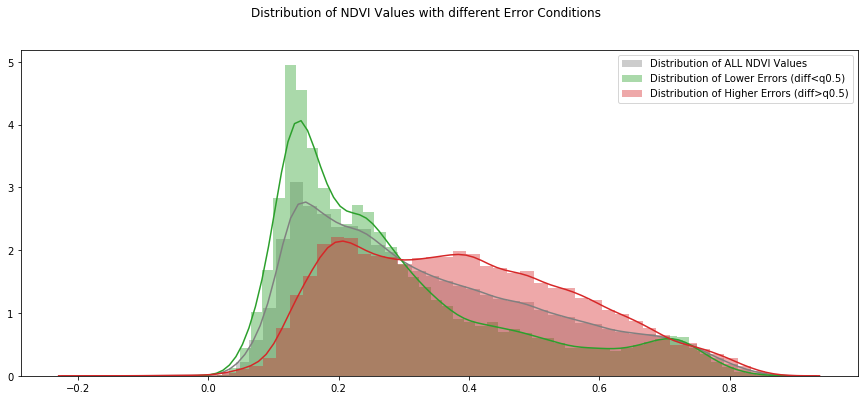

In [331]:
fig,ax=plt.subplots(figsize=(15,6))
sns.distplot(drop_nans_and_flatten(ds.true), label='Distribution of ALL NDVI Values', color='grey')
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_lower)), label='Distribution of Lower Errors (diff<q0.5)', color=sns.color_palette()[2])
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_upper)), label='Distribution of Higher Errors (diff>q0.5)', color=sns.color_palette()[3])
plt.legend();
fig.suptitle(f'Distribution of NDVI Values with different Error Conditions'); #\ne.g. (Abs Diff) is > q0.95');''


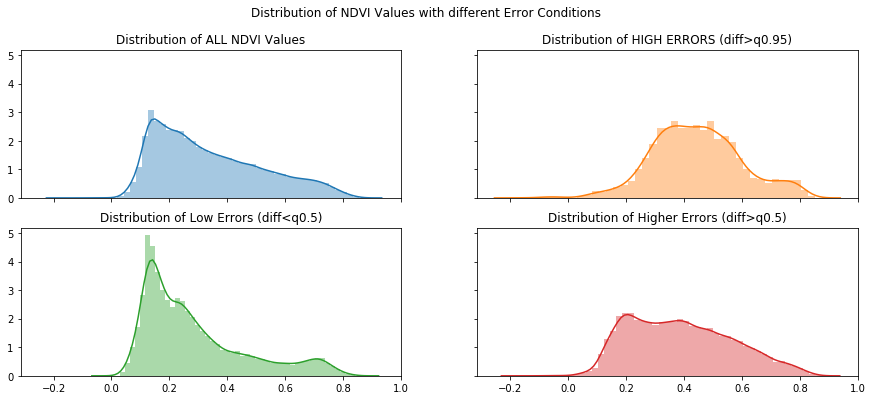

In [327]:
mask_q95=get_values_based_on_error_condition(ds, q=0.95, gt_lt="gt")
mask_q50_lower=get_values_based_on_error_condition(ds, q=0.5, gt_lt="lt")
mask_q50_upper=get_values_based_on_error_condition(ds, q=0.5, gt_lt="gt")

fig,((ax0,ax1),(ax2,ax3))=plt.subplots(2,2,figsize=(15,6),sharex=True,sharey=True)
sns.distplot(drop_nans_and_flatten(ds.true),ax=ax0, label='Distribution of ALL NDVI Values', color=sns.color_palette()[0])
ax0.set_title('Distribution of ALL NDVI Values')
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q95)),ax=ax1, label='Distribution of HIGH ERRORS (diff>q0.95)', color=sns.color_palette()[1])
ax1.set_title('Distribution of HIGH ERRORS (diff>q0.95)')
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_lower)),ax=ax2, label='Distribution of Low Errors (diff<q0.5)', color=sns.color_palette()[2])
ax2.set_title('Distribution of Low Errors (diff<q0.5)')
sns.distplot(drop_nans_and_flatten(ds.true.where(mask_q50_upper)),ax=ax3, label='Distribution of Higher Errors (diff>q0.5)', color=sns.color_palette()[3])
ax3.set_title('Distribution of Higher Errors (diff>q0.5)')
# plt.legend();
fig.suptitle(f'Distribution of NDVI Values with different Error Conditions'); #\ne.g. (Abs Diff) is > q0.95');''

# sns.distplot()